# Passive Entropy Production

In [45]:
import numpy as np
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt

z = 1
dpival = 2000
cmapname = "summer"
font = {'family': 'serif', 'serif': ['Computer Modern']}
line = {'linewidth': 2/z, 'linestyle' : 'solid'}
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **font)  # pass in the font dict as kwargs
matplotlib.rc('font', weight='bold')  # pass in the font dict as kwargs
matplotlib.rc('lines', **line)
matplotlib.rc('axes', labelsize=20/z, labelweight = 'bold')
matplotlib.rc('legend', fontsize=15/z, frameon=False)
matplotlib.rc('xtick.major', size=2/z)
matplotlib.rc('ytick.major', size=2/z)
matplotlib.rc('xtick', labelsize=20/z, direction='in')
matplotlib.rc('ytick', labelsize=20/z, direction='in')

def compute_Pt(x, T, t, p_alpha, mu_alpha, h_alpha):
    a = np.exp(-2*t)
    Delta = T * (1 - np.exp(-2 * t))
    Pt_x = np.sum(
        [
            (p / np.sqrt(Delta + h * a**2)) * np.exp(-((x - a * mu)**2) / (2 * (Delta + a**2 * h)))
            for p, mu, h in zip(p_alpha, mu_alpha, h_alpha)
        ]
    )
    return Pt_x

def compute_J(x, T, t, p_alpha, mu_alpha, h_alpha):
    a = np.exp(-2*t)
    Delta = T * (1 - np.exp(-2 * t))
    J_x = np.sum(
        [
            (p / np.sqrt(Delta + h * a**2)) * np.exp(-((x - a * mu)**2) / (2 * (Delta + a**2 * h)))
            * (T * (x - a * mu) / (Delta + a**2 * h) - x)
            for p, mu, h in zip(p_alpha, mu_alpha, h_alpha)
        ]
    )
    return J_x

def compute_J2_TPt(x_vals, T, t, p_alpha, mu_alpha, h_alpha):
    J_vals = np.array([compute_J(x, T, t, p_alpha, mu_alpha, h_alpha) for x in x_vals])
    Pt_vals = np.array([compute_Pt(x, T, t, p_alpha, mu_alpha, h_alpha) for x in x_vals])
    result = (J_vals ** 2) / (T * Pt_vals)
    return result

def compute_epr_passive(T, t, p_alphas, mu_alphas, h_alphas, x_min=-10, x_max=10):
    def integrand(x):
        J_x = compute_J(x, T, t, p_alphas, mu_alphas, h_alphas)
        Pt_x = compute_Pt(x, T, t, p_alphas, mu_alphas, h_alphas)
        return (J_x**2) / (T * Pt_x) if Pt_x > 0 else 0  # Avoid division by zero
    
    result, error = integrate.quad(integrand, x_min, x_max)
    return 1/(np.sqrt(2*np.pi)) * result

# Underdamped (Equivalent to Active with harmonic potential)

In [2]:
def Q_mat(m, zeta, t):
    gamma = zeta/m
    Omega = np.sqrt(1/m)
    # Discriminant (assumes γ^2 >= 4Ω^2 for a real sqrt)
    disc = gamma**2 - 4*(Omega**2)
    sqrt_disc = np.lib.scimath.sqrt(disc)

    # Precompute exponential factors
    exp_minus = np.exp(0.5 * t * (-gamma - sqrt_disc))  # e^(t/2 * (-γ - √disc))
    exp_plus  = np.exp(0.5 * t * (-gamma + sqrt_disc))  # e^(t/2 * (-γ + √disc))

    # First row
    Q11 = (- exp_minus * (gamma - sqrt_disc) / (2.0 * sqrt_disc)
           + exp_plus  * (gamma + sqrt_disc) / (2.0 * sqrt_disc))
    Q12 = (- exp_minus / sqrt_disc
           + exp_plus  / sqrt_disc)

    # Second row
    Q21 = (  exp_minus * (Omega**2) / sqrt_disc
           - exp_plus  * (Omega**2) / sqrt_disc)
    Q22 = (- exp_minus * (-gamma - sqrt_disc) / (2.0 * sqrt_disc)
           + exp_plus  * (-gamma + sqrt_disc) / (2.0 * sqrt_disc))

    return np.real([[Q11, Q12],
            [Q21, Q22]])

In [3]:
def C_mat(m, zeta, T, t):
    gamma = zeta/m
    Omega = np.sqrt(1/m)
    # Compute the discriminant and its square root
    disc = gamma**2 - 4 * Omega**2
    sqrt_disc = np.sqrt(disc)

    # Precompute exponential and hyperbolic functions
    exp_neg_tgamma = np.exp(-t * gamma)  # e^(-tγ)
    exp_neg_tgamma_sqrt = np.exp(-t * (gamma + sqrt_disc))  # e^(-t(γ + √Δ))
    exp_pos_2sqrt = np.exp(2 * t * sqrt_disc)  # e^(2t√Δ)
    exp_pos_tgamma_sqrt = np.exp(t * (gamma + sqrt_disc))  # e^(t(γ + √Δ))
    exp_pos_tsqrt = np.exp(t * sqrt_disc)  # e^(t√Δ)
    cosh_tsqrt = np.cosh(t * sqrt_disc)  # cosh(t√Δ)

    # Compute C_11 and C_22
    common_factor = exp_neg_tgamma_sqrt / (4 * (gamma**3 - 4 * gamma * Omega**2))
    
    bracket1 = (- (1 + exp_pos_2sqrt - 2 * exp_pos_tgamma_sqrt) * gamma**2
                - 8 * exp_pos_tsqrt * (-1 + np.exp(t * gamma)) * Omega**2
                - (-1 + exp_pos_2sqrt) * gamma * sqrt_disc)

    bracket2 = (- (1 + exp_pos_2sqrt - 2 * exp_pos_tgamma_sqrt) * gamma**2
                - 8 * exp_pos_tsqrt * (-1 + np.exp(t * gamma)) * Omega**2
                + (-1 + exp_pos_2sqrt) * gamma * sqrt_disc)

    C11 = (exp_neg_tgamma_sqrt * bracket1) / (4 * Omega**2 * (gamma**3 - 4 * gamma * Omega**2))
    C22 = common_factor * bracket2

    # Compute C_12 and C_21 (which are identical)
    C12 = exp_neg_tgamma * (-1 + cosh_tsqrt) / (gamma**2 - 4 * Omega**2)
    C21 = C12  # Since the matrix is symmetric

    # Return the computed matrix C
    return (2*T*zeta/(m*m)) * np.real(np.array([[C11, C12],
                             [C21, C22]]))

In [4]:
def D_alpha_inv_mat(h_alpha, g):
    D_inv_11 = 1/h_alpha + 1/g
    D_inv_12 = -1/g
    D_inv_22 = 1/g
    D_inv = np.real([[D_inv_11, D_inv_12],
            [D_inv_12, D_inv_22]])
    return D_inv

In [5]:
def J_alpha_mat(D_alpha_inv, C, Q):
    # Convert inputs to NumPy arrays (in case they're lists or tuples)
    D_alpha_inv = np.array(D_alpha_inv, dtype=float)
    C = np.array(C, dtype=float)
    Q = np.array(Q, dtype=float)
    # Compute the inverse of C
    C_inv = np.linalg.inv(C)
    # Compute Q^T (transpose of Q)
    Q_T = Q.T
    # Compute Q^T * C^-1 * Q
    middle_term = Q_T.dot(C_inv).dot(Q)
    # J_alpha = D_alpha_inv + Q^T C^-1 Q
    J = D_alpha_inv + middle_term
    return J

In [6]:
def H_alpha_mat(C, Q, J_alpha):
    # Convert inputs to NumPy arrays (in case they're lists/tuples)
    #C = np.array(C, dtype=float)
    #Q = np.array(Q, dtype=float)
    #J_alpha = np.array(J_alpha, dtype=float)
    # Invert C
    C_inv = np.linalg.inv(C)
    # Compute H_alpha = C_inv - C_inv*Q*J_alpha*Q^T*C_inv
    # Use the @ operator for matrix multiplication
    J_alpha_inv = np.linalg.inv(J_alpha)
    term = C_inv @ Q @ J_alpha_inv @ Q.T @ C_inv
    H = C_inv - term
    return H

In [7]:
def V_alpha_vec(mu_alpha, D_alpha_inv, J_alpha, Q, C):
    """
    Compute the vector V_alpha = transpose(mu_alpha) * D_alpha_inv * inv(J_alpha) * transpose(Q) * inv(C).
    """
    mu_alpha = mu_alpha*np.array([[1.0, 1.0]])
    # Convert inputs to NumPy arrays
    mu_alpha = np.array(mu_alpha, dtype=float).reshape(1, -1)  # Ensure row vector
    D_alpha_inv = np.array(D_alpha_inv, dtype=float)
    J_alpha = np.array(J_alpha, dtype=float)
    Q = np.array(Q, dtype=float)
    C = np.array(C, dtype=float)
    # Compute the inverses
    J_alpha_inv = np.linalg.inv(J_alpha)
    C_inv = np.linalg.inv(C)
    # Compute V_alpha
    V = mu_alpha @ D_alpha_inv @ J_alpha_inv @ Q.T @ C_inv
    return V

In [8]:
def P_alpha(x, v, mu_alpha, w_alpha, h_alpha, g, m, zeta, T, t):
    # --------------------------
    # 1) Form the vectors mu and X
    # --------------------------
    mu = mu_alpha * np.array([1.0, 1.0])  # mu is 2D: [mu_alpha, mu_alpha]
    X = np.array([x, v])                 # X is 2D: [x, v]
    # Make sure shapes are consistent for matrix multiplication
    mu = mu.reshape(-1, 1)  # 2×1 column vector
    X = X.reshape(-1, 1)    # 2×1 column vector
    # Construct Q, C, D_alpha_inv, J_alpha, H_alpha, V_alpha
    Q = Q_mat(m, zeta, t)
    C = C_mat(m, zeta, T, t)
    D_alpha_inv = D_alpha_inv_mat(h_alpha, g)
    J_alpha = J_alpha_mat(D_alpha_inv, C, Q)
    H_alpha = H_alpha_mat(C, Q, J_alpha)
    V_alpha = V_alpha_vec(mu_alpha, D_alpha_inv, J_alpha, Q, C)
    # If V_alpha was passed as a row/column, ensure shape is 2×1 or 1×2 appropriately
    V_alpha = np.array(V_alpha, dtype=float).reshape(-1, 1)  # 2×1 column vector

    # --------------------------
    # 2) Compute determinants
    # --------------------------
    det_J = np.linalg.det(J_alpha)
    det_C = np.linalg.det(C)

    # --------------------------
    # 3) Compute the exponent parts
    #    - mu^T D_alpha_inv mu --> scalar
    #    - mu^T D_alpha_inv J_alpha^-1 D_alpha_inv mu --> scalar
    #    - X^T H_alpha X --> scalar
    #    - V_alpha^T X --> scalar
    # --------------------------
    # mu^T * D_alpha_inv * mu
    term1 = float(mu.T @ D_alpha_inv @ mu)
    
    # mu^T * D_alpha_inv * J_alpha^-1 * D_alpha_inv * mu
    J_alpha_inv = np.linalg.inv(J_alpha)
    term2 = float(mu.T @ D_alpha_inv @ J_alpha_inv @ D_alpha_inv @ mu)

    # X^T * H_alpha * X
    term3 = float(X.T @ H_alpha @ X)

    # V_alpha^T * X
    term4 = float(V_alpha.T @ X)

    # Exponent = -1/2 * term1 + 1/2 * term2 - 1/2 * term3 + term4
    exponent = -0.5 * term1 + 0.5 * term2 - 0.5 * term3 + term4

    # --------------------------
    # 4) Combine the prefactors
    # w_alpha / sqrt(h_alpha * g) * 1 / sqrt(det(J_alpha)*det(C))
    # --------------------------
    prefactor = (
        w_alpha / np.sqrt(h_alpha * g)
        * 1.0 / np.sqrt(det_J * det_C)
    )

    # --------------------------
    # 5) Final computation of P_alpha
    # --------------------------
    P = prefactor * np.exp(exponent)

    return P

def P_total(x, v, mu_alpha, w_alpha, h_alpha, g, m, zeta, T, t):
    P = 0.0
    for mu_alpha, h_alpha, w_alpha in zip(mu_alphas, h_alphas, w_alphas):
        P_a = P_alpha(x, v, mu_alpha, w_alpha, h_alpha, g, m, zeta, T, t)
        P = P + P_a
    return P

# Test if Probability is normalized (currently it should give a value of 2\pi)

In [9]:
import scipy.integrate as spi
def integrate_P_total(mu_alpha, w_alpha, h_alpha, g, m, zeta, T, t):
    # Define a wrapper function that only takes x and v, with other parameters fixed
    def P_total_wrapper(x, v):
        return P_total(x, v, mu_alpha, w_alpha, h_alpha, g, m, zeta, T, t)

    # Perform double integral over x ∈ [-10,10] and v ∈ [-10,10]
    result, error = spi.dblquad(P_total_wrapper,  # Function to integrate
                                -10, 10,          # x integration limits
                                lambda x: -10, lambda x: 10)  # v limits
    return result

# Now write the code for the probability current J

In [10]:
def P_J_alpha(x, v, mu_alpha, w_alpha, h_alpha, g, m, zeta, T, t):
    # --------------------------
    # 1) Form the vectors mu and X
    # --------------------------
    mu = mu_alpha * np.array([1.0, 1.0])  # mu is 2D: [mu_alpha, mu_alpha]
    X = np.array([x, v])                 # X is 2D: [x, v]
    # Make sure shapes are consistent for matrix multiplication
    mu = mu.reshape(-1, 1)  # 2×1 column vector
    X = X.reshape(-1, 1)    # 2×1 column vector
    # Construct Q, C, D_alpha_inv, J_alpha, H_alpha, V_alpha
    Q = Q_mat(m, zeta, t)
    C = C_mat(m, zeta, T, t)
    D_alpha_inv = D_alpha_inv_mat(h_alpha, g)
    J_alpha = J_alpha_mat(D_alpha_inv, C, Q)
    H_alpha = H_alpha_mat(C, Q, J_alpha)
    V_alpha = V_alpha_vec(mu_alpha, D_alpha_inv, J_alpha, Q, C)
    # If V_alpha was passed as a row/column, ensure shape is 2×1 or 1×2 appropriately
    V_alpha = np.array(V_alpha, dtype=float).reshape(-1, 1)  # 2×1 column vector
    # --------------------------
    # 2) Compute determinants
    # --------------------------
    det_J = np.linalg.det(J_alpha)
    det_C = np.linalg.det(C)
    # --------------------------
    # 3) Compute the exponent parts
    #    - mu^T D_alpha_inv mu --> scalar
    #    - mu^T D_alpha_inv J_alpha^-1 D_alpha_inv mu --> scalar
    #    - X^T H_alpha X --> scalar
    #    - V_alpha^T X --> scalar
    # --------------------------
    # mu^T * D_alpha_inv * mu
    term1 = float(mu.T @ D_alpha_inv @ mu)
    # mu^T * D_alpha_inv * J_alpha^-1 * D_alpha_inv * mu
    J_alpha_inv = np.linalg.inv(J_alpha)
    term2 = float(mu.T @ D_alpha_inv @ J_alpha_inv @ D_alpha_inv @ mu)
    # X^T * H_alpha * X
    term3 = float(X.T @ H_alpha @ X)
    # V_alpha^T * X
    term4 = float(V_alpha.T @ X)
    # Exponent = -1/2 * term1 + 1/2 * term2 - 1/2 * term3 + term4
    exponent = -0.5 * term1 + 0.5 * term2 - 0.5 * term3 + term4
    # --------------------------
    # 4) Combine the prefactors
    # w_alpha / sqrt(h_alpha * g) * 1 / sqrt(det(J_alpha)*det(C))
    # --------------------------
    prefactor = (
        w_alpha / np.sqrt(h_alpha * g)
        * 1.0 / np.sqrt(det_J * det_C)
    )

    # --------------------------
    # 5) Final computation of P_alpha
    # --------------------------
    P = prefactor * np.exp(exponent)
    J = (zeta/m) * P * ( v + (T/m)*( V_alpha[1,0] - H_alpha[1,1]*v - H_alpha[0,1]*x ) )
    return P, J

def epr_x_v(x, v, mu_alphas, w_alphas, h_alphas, g, m, zeta, T, t):
    P = 0.0
    J = 0.0
    for mu_alpha, h_alpha, w_alpha in zip(mu_alphas, h_alphas, w_alphas):
        P_a, J_a = P_J_alpha(x, v, mu_alpha, w_alpha, h_alpha, g, m, zeta, T, t)
        P = P + P_a
        J = J + J_a
    return J**2 / P

def entropy_production(mu_alphas, w_alphas, h_alphas, g, m, zeta, T, t):
    def epr_total_wrapper(x, v):
        return epr_x_v(x, v, mu_alphas, w_alphas, h_alphas, g, m, zeta, T, t)

    # Perform double integral over x ∈ [-10,10] and v ∈ [-10,10]
    result, error = spi.dblquad(epr_total_wrapper,  # Function to integrate
                                -10, 10,          # x integration limits
                                lambda x: -5, lambda x: 5)  # v limits
    return ((m*m)/(T*zeta)) * (1/(2*np.pi)) * result

In [48]:
tau = 0.7
Tp = 1.0
Ta = 1.0
m = tau
zeta = 1 + tau
gamma = zeta/m
Omega = np.sqrt(1/m)
T = Ta/(1+tau)
mu_alphas = [2] 
h_alphas = [0.2]
w_alphas = [1.0]
tlist = np.linspace(0.1, 4.0, 79)
g = Ta/tau

In [12]:
epr_passive_list = []
epr_active_list = []
for t in tlist:
    epr_passive = compute_epr_passive(Tp, t, w_alphas, mu_alphas, h_alphas)
    epr_passive_list.append(epr_passive)
    epr_active = entropy_production(mu_alphas, w_alphas, h_alphas, g, m, zeta, T, t)
    epr_active_list.append(epr_active)
    print("{}: Passive: {} , Active: {}".format(t, epr_passive, epr_active))

0.1: Passive: 4.16786157399359 , Active: 5.756379777840968
0.15: Passive: 3.274628308763344 , Active: 3.6848501078336677
0.2: Passive: 2.6003919039601646 , Active: 2.2802460518613645
0.25: Passive: 2.0796832508007075 , Active: 1.3712266146016796
0.3: Passive: 1.6715165357610007 , Active: 0.8281458276088829
0.35: Passive: 1.3483101600492367 , Active: 0.5535689630875519
0.4: Passive: 1.0905396779010499 , Active: 0.4737209240698949
0.44999999999999996: Passive: 0.8838800422928001 , Active: 0.5320187989630527
0.5: Passive: 0.7175475402242386 , Active: 0.684628362720878
0.5499999999999999: Passive: 0.583271314567692 , Active: 0.8974916229203008
0.6: Passive: 0.47461980620650956 , Active: 1.1442779537603203
0.6499999999999999: Passive: 0.38653985493960386 , Active: 1.4048819381301259
0.7: Passive: 0.3150300305429218 , Active: 1.6642509757296267
0.7499999999999999: Passive: 0.2569025259278136 , Active: 1.9114293961702764
0.7999999999999999: Passive: 0.20960570484679333 , Active: 2.13876159131

In [13]:
epr_active_list = np.asarray(epr_active_list)
epr_passive_list = np.asarray(epr_passive_list)

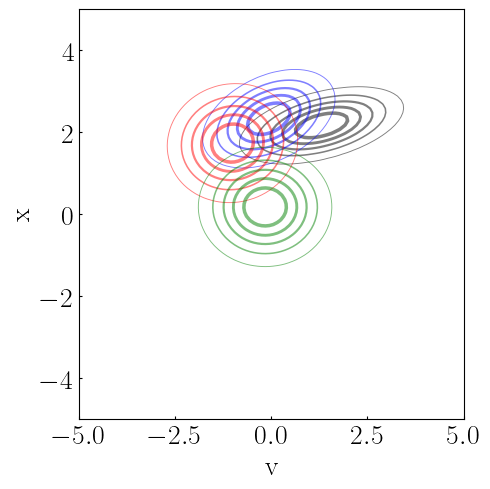

In [68]:
L = 100
xlist = np.linspace(-5, 5, L)
vlist = np.linspace(-5, 5, L)
X, Y = np.meshgrid(xlist, vlist)
tidx1 = 0
tidx2 = 6
tidx3 = 22
tidx4 = 78
tlist_for_dist = [tlist[tidx1], tlist[tidx2], tlist[tidx3], tlist[tidx4]]
colorlist = ['black', 'blue', 'red', 'green']
fig, ax = plt.subplots(figsize=(5,5))

def scale_linewidths(levels):
    min_width, max_width = 0.2, 3  # Define min and max linewidths
    normalized_levels = (levels - levels.min()) / (levels.max() - levels.min())  # Normalize to [0,1]
    return min_width + normalized_levels * (max_width - min_width)  # Scale

for (t,color) in zip(tlist_for_dist,colorlist):
    P_xv_mat = np.zeros((L, L))
    for i in range(L):
        x = xlist[i]
        for j in range(L):
            v = vlist[j]
            P_xv_mat[i, j] = P_total(x, v, mu_alphas, w_alphas, h_alphas, g, m, zeta, T, t)
    levels = np.linspace(P_xv_mat.min(), P_xv_mat.max(), 7)
    linewidths = scale_linewidths(levels)
    contour = ax.contour(X, Y, P_xv_mat, levels=levels, colors=color, linewidths=linewidths, alpha=0.5)
    #ax.imshow(
    #    P_xv_mat, 
    #    extent=[-5, 5, -5, 5], 
    #    origin='lower',
    #    alpha=0.7
    #)

#cbar = fig.colorbar(heatmap, ax=ax)
ax.set_xlabel('v')
ax.set_ylabel('x')
#ax.set_title('Heatmap)
plt.tight_layout()
plt.savefig("Distributions_at_different_times.png")
plt.savefig("Distributions_at_different_times.svg")
plt.savefig("Distributions_at_different_times.pdf")

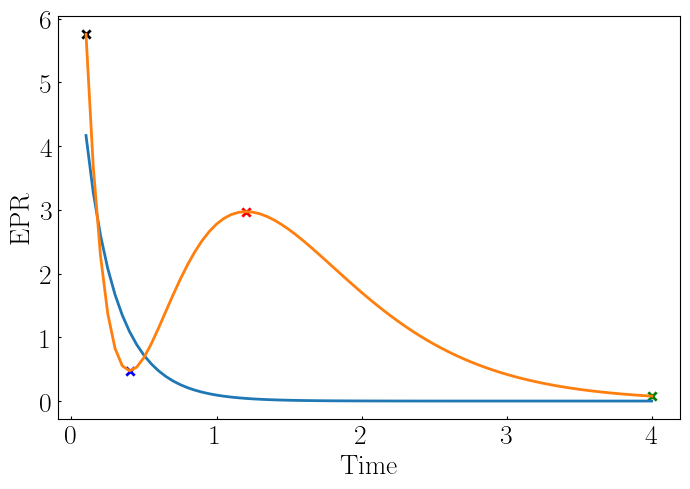

In [70]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(tlist, epr_passive_list)
ax.plot(tlist, epr_active_list)
ax.scatter(tlist[tidx1], epr_active_list[tidx1], marker='x', color='k')
ax.scatter(tlist[tidx2], epr_active_list[tidx2], marker='x', color='b')
ax.scatter(tlist[tidx3], epr_active_list[tidx3], marker='x', color='r')
ax.scatter(tlist[tidx4], epr_active_list[tidx4], marker='x', color='g')
ax.set_xlabel("Time")
ax.set_ylabel("EPR")
plt.tight_layout()
plt.savefig("EPR.png")
plt.savefig("EPR.pdf")
plt.savefig("EPR.svg")

In [53]:
tlist[12]

0.7

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

###############################
# 1. DUMMY DATA/FUNCTION
###############################
# Replace these with your real data and definitions:

L = 100
xlist = np.linspace(-5, 5, L)
vlist = np.linspace(-5, 5, L)

# Times at which we compute everything
tlist = np.linspace(0.1, 5.0, 50)  # Example: 50 frames


###############################
# 2. CREATE THE FIGURE/AXES
###############################
# We'll create 2 subplots: (left) the heatmap, (right) the EPR vs t.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 2.1. Heatmap initialization (left panel)
P_xv_mat = np.zeros((L, L))
heatmap = ax1.imshow(
    P_xv_mat, 
    extent=[-5, 5, -5, 5], 
    origin='lower'
)
cbar = fig.colorbar(heatmap, ax=ax1)
ax1.set_xlabel('v')
ax1.set_ylabel('x')
ax1.set_title('Heatmap')

# 2.2. Lines initialization (right panel)
# We'll dynamically update these two lines as time progresses.
line_active,  = ax2.plot([], [], 'r-', label='Active')
line_passive, = ax2.plot([], [], 'b-', label='Passive')

ax2.set_xlim(tlist[0], tlist[-1])  # x-axis from min(t) to max(t)
# For y-limits, pick something suitable or adapt dynamically.
# Example: we set them just wide enough to fit your data.
ymin = min(epr_active_list.min(), epr_passive_list.min())
ymax = max(epr_active_list.max(), epr_passive_list.max())
ax2.set_ylim(ymin, ymax)

ax2.set_xlabel('Time')
ax2.set_ylabel('EPR')
ax2.legend()
ax2.set_title('EPR vs Time')


###############################
# 3. ANIMATION FUNCTIONS
###############################
def init_animation():
    """
    This function is called once at the beginning of the animation.
    Here we reset or clear data to initial state.
    """
    # Clear the heatmap
    P_xv_mat[:] = 0.0
    heatmap.set_array(P_xv_mat)

    # Clear the lines on the EPR vs Time axis
    line_active.set_data([], [])
    line_passive.set_data([], [])

    return [heatmap, line_active, line_passive]

def update(frame):
    """
    This function is called for each frame in the animation,
    with frame = 0, 1, 2, ... up to len(tlist)-1.
    """
    t = tlist[frame]

    # 3.1. Update the heatmap data for this time
    for i in range(L):
        x = xlist[i]
        for j in range(L):
            v = vlist[j]
            P_xv_mat[i, j] = P_total(x, v, mu_alphas, w_alphas, h_alphas, g, m, zeta, T, t)

    heatmap.set_array(P_xv_mat)
    heatmap.set_clim(vmin=P_xv_mat.min(), vmax=P_xv_mat.max())  # keep color scale in sync
    ax1.set_title(f'Heatmap (t = {t:.2f})')

    # 3.2. Update the lines up to this frame
    # e.g., show data up to current index 'frame'.
    line_active.set_data(tlist[:frame+1], epr_active_list[:frame+1])
    line_passive.set_data(tlist[:frame+1], epr_passive_list[:frame+1])

    ax2.set_title(f'EPR vs Time (t = {t:.2f})')

    # Return all artists that changed
    return [heatmap, line_active, line_passive]

###############################
# 4. BUILD & DISPLAY ANIMATION
###############################
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(tlist),
    init_func=init_animation,
    blit=False,   # We have multiple artists: heatmap + lines + colorbar
    repeat=True
)

plt.close(fig)
# If in Jupyter, display inline:
HTML(ani.to_jshtml())

# If in a standard script, remove the HTML call and do:
# plt.show()


In [69]:
ani.save("1Peak.mp4")